### Ньяти Каелиле БВТ2201
### Лаб 2 50 Multilayer Perceptron

### Importing necessary dependencies

In [1]:
# импорт пакетов
%pip install torch torchvision matplotlib numpy scikit-learn seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import torch.optim as optim
from tqdm import tqdm  # For progress bar
from torch.utils.data import Subset

### Use GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Используемое устройство:", device)

Используемое устройство: cuda


### MultiLayer Perceptron - 50 layers, skip connections, batch processing, ReLu activation function

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, num_classes=10, num_layers=50, dropout=0.2):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()

        # Input layer
        self.input_layer = nn.Linear(input_size, hidden_size)

        # Hidden layers with skip connections (each block has 2 layers)
        self.hidden_layers = nn.ModuleList()
        for _ in range((num_layers - 2) // 2):
            block = nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
            self.hidden_layers.append(block)

        # Output layer
        self.output_layer = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.input_layer(x)

        for block in self.hidden_layers:
            x = x + block(x)  # Skip connection every 2 layers

        x = self.output_layer(x)
        return x  # No softmax (handled in loss function)

    # Instantiate and print the model
model = MLP()
print(model)

# Move the model to CUDA
model = MLP().to(device)



MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (input_layer): Linear(in_features=784, out_features=256, bias=True)
  (hidden_layers): ModuleList(
    (0-23): 24 x Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
    )
  )
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
)


### Train mode

In [5]:
model.train()

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (input_layer): Linear(in_features=784, out_features=256, bias=True)
  (hidden_layers): ModuleList(
    (0-23): 24 x Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
    )
  )
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
)

### Transformations (convert image to tensor, normalize)

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to (-1,1) for stable training
])

### Loading MNIST train dataset

In [7]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform) #train dataset has 60 000 images

num_samples_per_class = 1000 #MNIST has 10 classes
class_indices = {i: [] for i in range(10)}  # Store indices per class

# Collect indices for each class
for idx, (_, label) in enumerate(train_dataset):
    if len(class_indices[label]) < num_samples_per_class:
        class_indices[label].append(idx)

# Flatten the list of selected indices
selected_indices = [idx for indices in class_indices.values() for idx in indices]
train_subset = torch.utils.data.Subset(train_dataset, selected_indices)

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=16, shuffle=True)

#print(len(train_dataset))  # Total number of images in the dataset
print("subset length: ", len(train_subset))

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:11<00:00, 891kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.28MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

subset length:  10000


### Load MNIST test dataset

In [8]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


num_samples_per_class = 200 #MNIST has 10 classes
class_indices = {i: [] for i in range(10)}  # Store indices per class

# Collect indices for each class
for idx, (_, label) in enumerate(train_dataset):
    if len(class_indices[label]) < num_samples_per_class:
        class_indices[label].append(idx)

# Flatten the list of selected indices
selected_indices = [idx for indices in class_indices.values() for idx in indices]
test_subset = torch.utils.data.Subset(test_dataset, selected_indices)

test_loader = torch.utils.data.DataLoader(test_subset, batch_size=16, shuffle=True)

print("subset length: ", len(test_subset))

subset length:  2000


### Checking the images

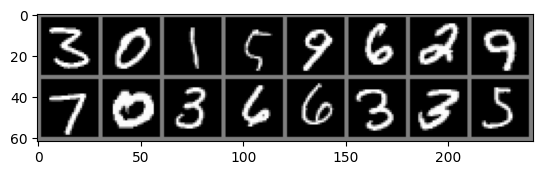

'\n# Loop through the DataLoader and visualize each batch\nfor i, (images, labels) in enumerate(train_loader):\n    print(f"Batch {i+1}")\n    imshow(torchvision.utils.make_grid(images))\n\n    # Stop after visualizing a few batches (optional)\n    if i == 2:  # Visualize only the first 3 batches\n        break\n\n'

In [26]:
# Denormalize function for MNIST (since we're using (0.5,) mean and std)
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean, device=tensor.device).view(1, 1, 1)  # Move to same device
    std = torch.tensor(std, device=tensor.device).view(1, 1, 1)  # Reshape to (1, 1, 1) for broadcasting (grayscale)
    return tensor * std + mean  # Reverse normalization


# Function to show images
def imshow(img):
    img = denormalize(img, mean=[0.5], std=[0.5])  # Denormalize for MNIST
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')  # Use 'gray' for grayscale images
    plt.show()

# Get a batch of images and labels from the DataLoader
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))

'''
# Loop through the DataLoader and visualize each batch
for i, (images, labels) in enumerate(train_loader):
    print(f"Batch {i+1}")
    imshow(torchvision.utils.make_grid(images))

    # Stop after visualizing a few batches (optional)
    if i == 2:  # Visualize only the first 3 batches
        break

'''

### Using CrossEntropyLoss for calculating loss, and SGD for optimization

In [10]:
criterion = nn.CrossEntropyLoss() #Cross entropy already handles softmax so no need to apply it
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Training the MLP model

#### One-hot encoding

In [15]:
def one_hot_encode(labels, num_classes=10):
    return torch.eye(num_classes, device=labels.device)[labels]


### ArgMax

In [12]:
def reverse_transform_one_hot(one_hot_labels):
    return torch.argmax(one_hot_labels, dim=1)  # Get the class index by taking argmax across the one-hot vector


Epoch 1/10: 100%|██████████| 625/625 [00:20<00:00, 33.54it/s, loss=0.14]

Epoch 1/10, Loss: 1.2286



Epoch 2/10:   1%|          | 4/625 [00:00<00:18, 34.15it/s, loss=0.482]

Epoch 2/10: 100%|██████████| 625/625 [00:24<00:00, 25.35it/s, loss=1.6]

Epoch 2/10, Loss: 0.6261


Epoch 3/10: 100%|█████████▉| 624/625 [00:20<00:00, 34.58it/s, loss=0.00832]

Epoch 3/10, Loss: 0.4438



Epoch 4/10:   1%|          | 4/625 [00:00<00:20, 30.21it/s, loss=0.0159]

Epoch 4/10: 100%|█████████▉| 624/625 [00:25<00:00, 22.45it/s, loss=0.193]

Epoch 4/10, Loss: 0.4055


Epoch 5/10: 100%|█████████▉| 624/625 [00:19<00:00, 31.96it/s, loss=0.214]

Epoch 5/10, Loss: 0.3357



Epoch 6/10:   0%|          | 3/625 [00:00<00:21, 29.22it/s, loss=0.288]

Epoch 6/10: 100%|█████████▉| 624/625 [00:26<00:00, 24.27it/s, loss=0.349] 

Epoch 6/10, Loss: 0.3650


Epoch 7/10: 100%|█████████▉| 624/625 [00:20<00:00, 32.06it/s, loss=0.0345]

Epoch 7/10, Loss: 0.2586



Epoch 8/10:   0%|          | 0/625 [00:00<?, ?it/s, loss=0.0333]

Epoch 8/10: 100%|█████████▉| 624/625 [00:27<00:00, 24.31it/s, loss=0.0661]

Epoch 8/10, Loss: 0.3288


Epoch 9/10: 100%|██████████| 625/625 [00:21<00:00, 32.12it/s, loss=0.365]

Epoch 9/10, Loss: 0.3291



                                                                         
Epoch 10/10: 100%|█████████▉| 624/625 [00:27<00:00, 22.05it/s, loss=0.249]

Epoch 10/10, Loss: 0.2607


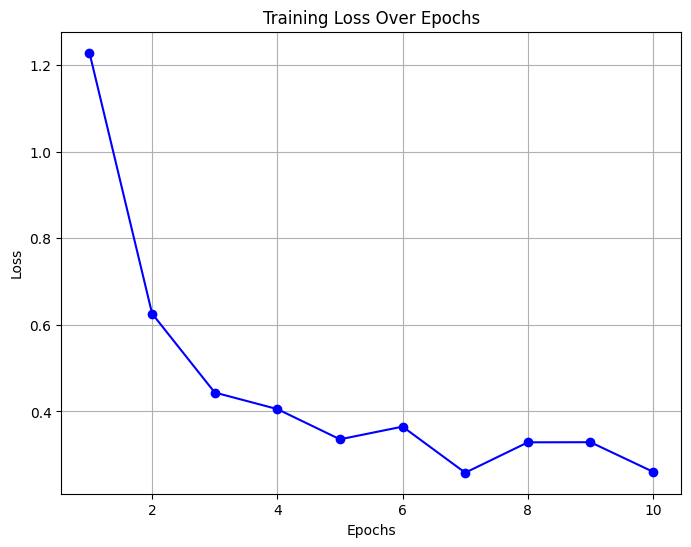

One Hot true labels [2, 0, 4, 8, 8, 7, 7, 7, 4, 6, 3, 0, 7, 7, 3, 3, 1, 9, 7, 9, 6, 6, 9, 5, 2, 1, 8, 5, 7, 2, 6, 8, 1, 2, 5, 9, 5, 9, 1, 9, 2, 5, 1, 4, 9, 0, 3, 8, 8, 6, 4, 3, 8, 3, 2, 2, 9, 2, 7, 2, 3, 3, 6, 3, 7, 1, 5, 4, 5, 5, 9, 7, 9, 8, 5, 9, 4, 0, 7, 9, 5, 2, 7, 7, 2, 7, 6, 0, 8, 8, 8, 1, 3, 8, 0, 4, 1, 1, 7, 1, 2, 7, 9, 3, 5, 2, 4, 7, 5, 3, 3, 8, 1, 8, 2, 6, 2, 1, 8, 9, 5, 6, 6, 6, 3, 8, 6, 5, 4, 1, 2, 6, 4, 7, 1, 8, 0, 3, 5, 7, 7, 6, 0, 5, 5, 2, 0, 2, 5, 6, 0, 4, 1, 4, 7, 6, 0, 1, 3, 0, 8, 5, 4, 8, 4, 9, 6, 7, 8, 1, 0, 1, 0, 6, 6, 0, 7, 1, 0, 8, 5, 7, 5, 1, 4, 0, 1, 4, 3, 6, 9, 8, 7, 9, 7, 3, 5, 8, 7, 2, 5, 1, 2, 0, 8, 9, 0, 2, 6, 5, 1, 5, 1, 5, 7, 3, 3, 3, 2, 8, 5, 4, 5, 9, 2, 5, 2, 0, 5, 2, 9, 3, 1, 2, 3, 4, 9, 0, 6, 1, 3, 5, 8, 9, 8, 9, 9, 2, 3, 0, 5, 9, 0, 7, 3, 5, 0, 0, 8, 4, 9, 1, 0, 3, 4, 9, 5, 7, 3, 8, 6, 1, 9, 1, 5, 0, 0, 9, 1, 1, 6, 9, 8, 2, 1, 4, 5, 2, 9, 2, 8, 2, 0, 3, 3, 8, 3, 9, 8, 8, 3, 9, 8, 2, 7, 0, 7, 9, 0, 0, 3, 9, 2, 9, 5, 5, 3, 4, 7, 1, 4, 8, 3, 4, 7, 3, 9

In [16]:
num_epochs = 10
loss_history = []  # Store loss for visualization

true_labels_OHE = []
predicted_labels_OHE = []

for epoch in range(num_epochs):
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)  # Progress bar


    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # One-hot encode the labels
        one_hot_labels = one_hot_encode(labels).to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        #softmax = nn.Softmax(dim=1)
        #probabilities = softmax(outputs)

        # Get predicted class indices
        _, preds = torch.max(outputs, 1)

        # Convert predictions to one-hot (optional, for comparison)
        one_hot_preds = one_hot_encode(preds)

        # Reverse transformation from one-hot to class index
        predicted_class_indices = reverse_transform_one_hot(one_hot_preds)

        # Store true and predicted labels
        true_labels_OHE.extend(labels.cpu().numpy())  # Convert tensor to list
        predicted_labels_OHE.extend(predicted_class_indices.cpu().numpy())  # Convert tensor to list



        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix(loss=loss.item())  # Show current loss
        progress_bar.update(1)

    epoch_loss = running_loss / len(train_subset)
    loss_history.append(epoch_loss)  # Store loss per epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


# Plot Training Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), loss_history, marker='o', linestyle='-', color='b')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()
plt.show()

print("One Hot true labels", true_labels_OHE)
print("One Hot predicted", predicted_labels_OHE)


### Second Part: Testing

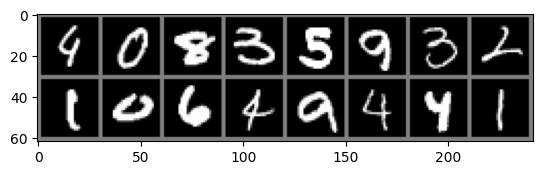

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (input_layer): Linear(in_features=784, out_features=256, bias=True)
  (hidden_layers): ModuleList(
    (0-23): 24 x Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
    )
  )
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
)

In [17]:
images, labels = next(iter(test_loader))
imshow(torchvision.utils.make_grid(images))

model.eval() #Inference mode

### Check class names and perform data cleaning

In [18]:
mnist_classes = test_dataset.classes
print(mnist_classes)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [19]:
cleaned_class_names = [name.split(' - ')[1] for name in mnist_classes]
print(cleaned_class_names)


['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']


### Predictions

In [20]:
true_labels = []
predicted_labels = []

# Disable gradient calculation (for faster inference)
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass: Get model predictions
        outputs = model(inputs)

        # Get predicted class indices
        _, preds = torch.max(outputs, 1)

        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())  # Convert tensor to list
        predicted_labels.extend(preds.cpu().numpy())  # Convert tensor to list

# Convert indices to class names
true_labels_names = [cleaned_class_names[i] for i in true_labels]
predicted_labels_names = [cleaned_class_names[i] for i in predicted_labels]

# Print some results
for i in range(10):  # Print first 10 examples
    print(f"True: {true_labels_names[i]}, Predicted: {predicted_labels_names[i]}")

True: three, Predicted: three
True: four, Predicted: four
True: seven, Predicted: seven
True: three, Predicted: eight
True: three, Predicted: three
True: three, Predicted: seven
True: two, Predicted: two
True: seven, Predicted: seven
True: three, Predicted: nine
True: two, Predicted: eight


### Classification report

              precision    recall  f1-score   support

        zero       0.90      0.99      0.95       180
         one       0.96      0.99      0.97       232
         two       0.94      0.87      0.90       216
       three       0.99      0.75      0.85       202
        four       0.97      0.67      0.79       218
        five       0.97      0.80      0.88       179
         six       0.89      0.95      0.92       186
       seven       0.84      0.87      0.86       204
       eight       0.87      0.88      0.88       191
        nine       0.61      0.99      0.76       192

    accuracy                           0.87      2000
   macro avg       0.89      0.88      0.87      2000
weighted avg       0.90      0.87      0.88      2000



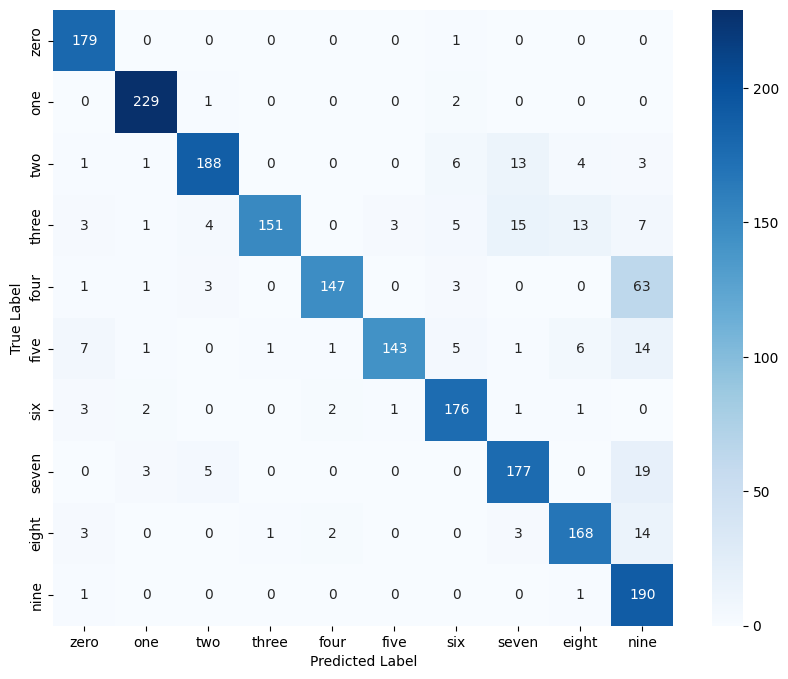

In [21]:
#Confusion matrix
print(classification_report(true_labels, predicted_labels, target_names=cleaned_class_names))

# постройте матрицу ошибок
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=cleaned_class_names, yticklabels=cleaned_class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Visualizing the predictions with images

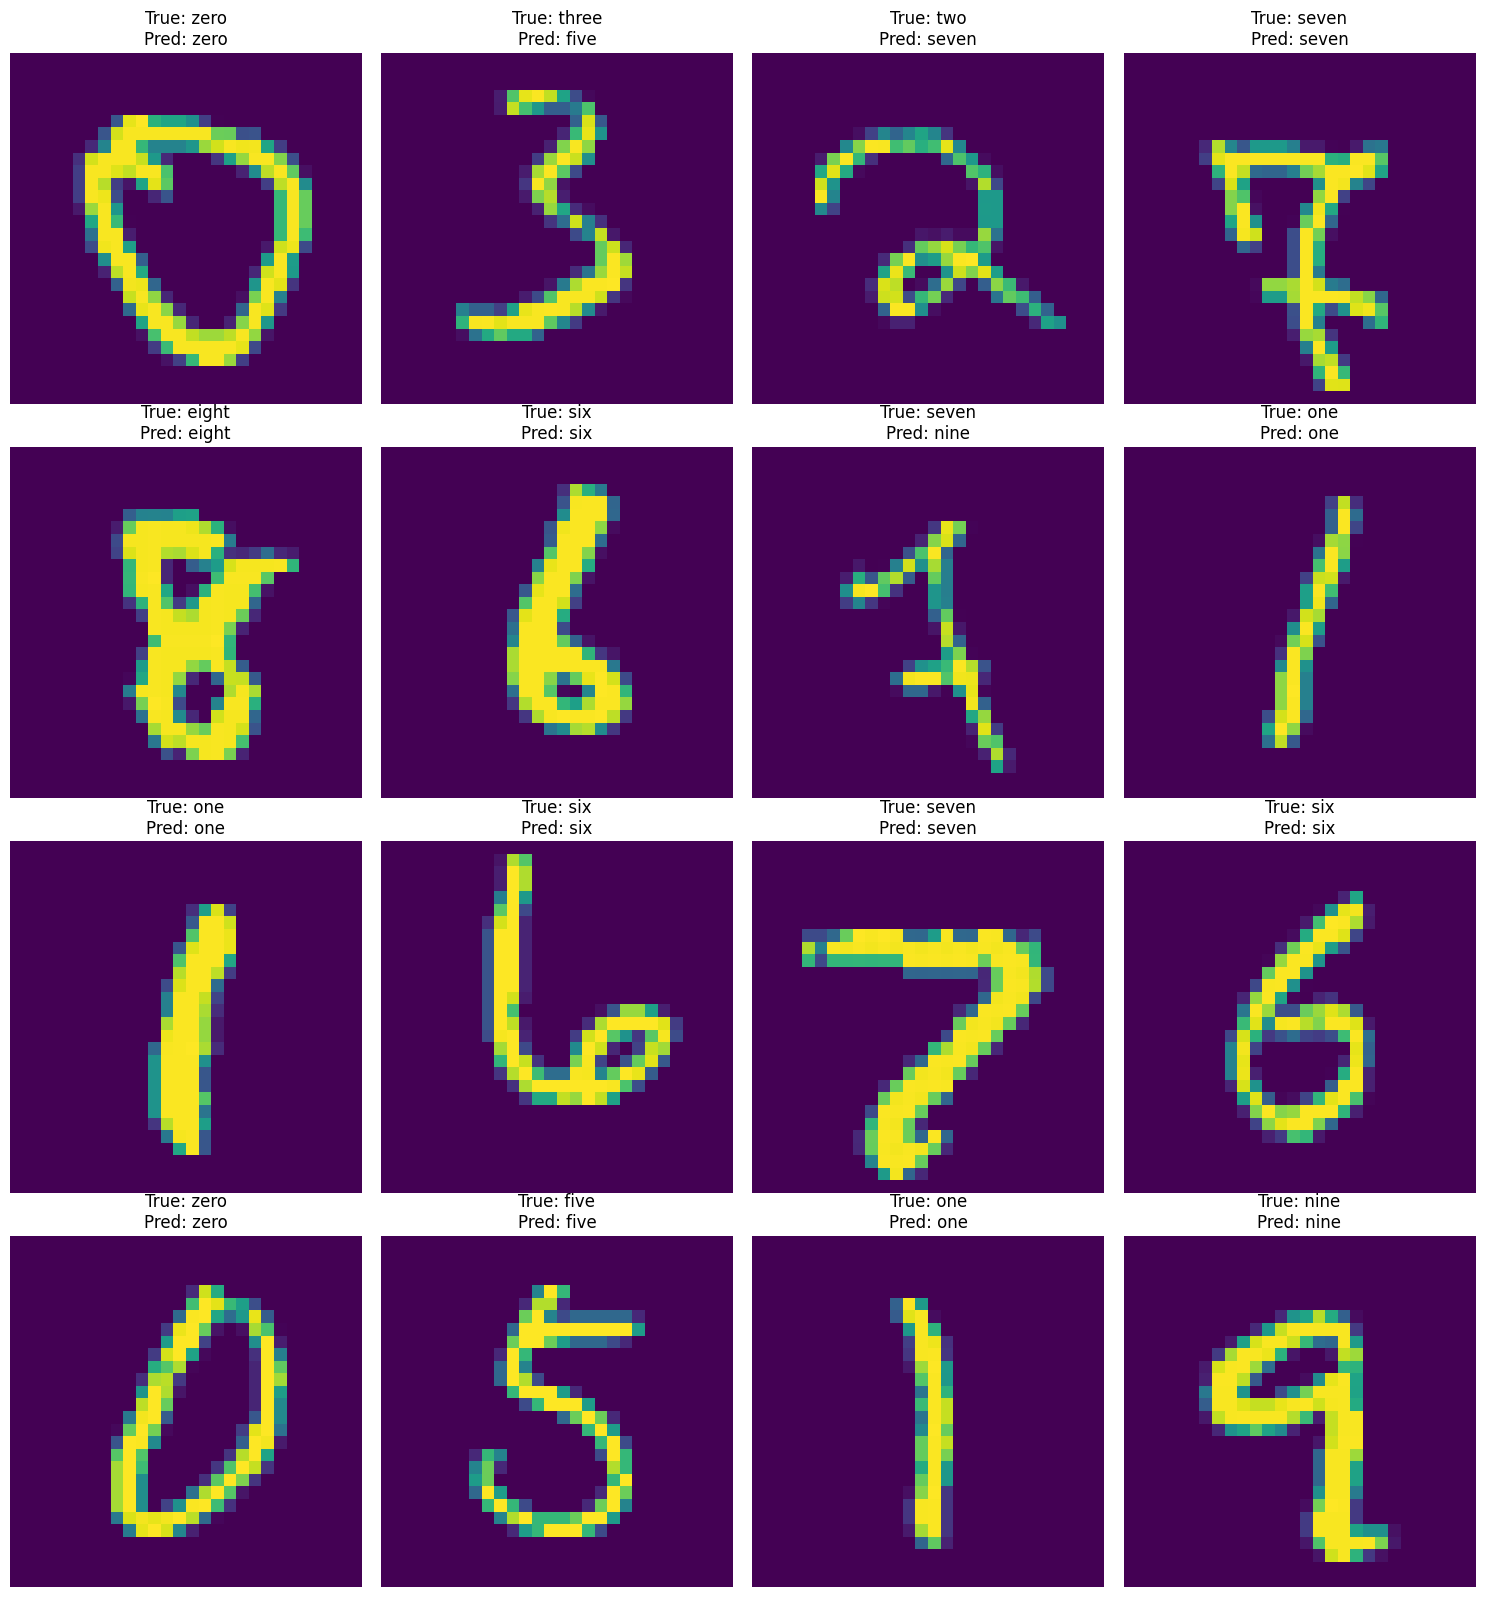

In [28]:
y_true = []
y_pred = []

model.to(device)  # Move model to GPU if available

# Disable gradient calculation (for faster inference)
with torch.no_grad():
    # Get a single batch from the test loader
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    # Forward pass: Get model predictions
    outputs = model(images)

    # Get predicted class indices
    _, preds = torch.max(outputs, 1)

    # Store true and predicted labels
    y_true.extend(labels.cpu().numpy())  # Convert tensor to list
    y_pred.extend(preds.cpu().numpy())  # Convert tensor to list

# Convert indices to class names
true_names = [cleaned_class_names[i] for i in y_true]
pred_names = [cleaned_class_names[i] for i in y_pred]

# Определяем количество изображений в батче
batch_size = images.size(0)
ncols = 4  # число столбцов для сетки изображений
nrows = (batch_size + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4 * nrows))
axes = axes.flatten()

for i in range(batch_size):
    img = denormalize(images[i], mean=[0.5], std=[0.5]).cpu().permute(1, 2, 0).numpy()
    ax = axes[i]
    ax.imshow(img)
    ax.set_title(f"True: {true_names[i]}\nPred: {pred_names[i]}")
    ax.axis('off')

# Если осей больше, чем изображений, скрываем лишние
for j in range(batch_size, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


### Save Model

In [24]:
# Save the model's state_dict (the learned parameters)
torch.save(model.state_dict(), 'model.pth')
print("Model saved!")

Model saved!


### Load Model

In [25]:
model = MLP()  # Re-initialize the same model architecture
model.load_state_dict(torch.load('model.pth'))  # Load the saved parameters

<ipython-input-25-7d7d197935b1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))  # Load the saved parameters


<All keys matched successfully>